<a href="https://colab.research.google.com/github/ColbertFS/CNN_cancer_de_pulmon/blob/main/Clasificaci%C3%B3n_de_c%C3%A1ncer_de_pulm%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cargar datos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Librerias**

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import random

Lectura de datos y preprocesamiento

In [ ]:
def preprocesamiento(ruta, img_size):
    #Generador de datos para aumentar el numero de imagenes
    datagen = ImageDataGenerator(
        rotation_range=20,       # Rango para las rotaciones aleatorias
        width_shift_range=0.2,   # Rango para los desplazamientos horizontales aleatorios
        height_shift_range=0.2,  # Rango para los desplazamientos verticales aleatorios
        shear_range=0.2,         # Rango para las transformaciones de corte aleatorias
        zoom_range=0.2,          # Rango para las zoom aleatorios
        horizontal_flip=True,    # Activa la opción de voltear las imágenes horizontalmente
        fill_mode='nearest'      # Estrategia para rellenar los píxeles que pueden quedar fuera de la imagen después de una transformación
    )

    imagenes = []
    for img in os.listdir(ruta):
        img = cv2.imread(os.path.join(ruta, img), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.0

        #Añadir una dimensión extra para los canales de color
        img = np.expand_dims(img, axis=-1)

        #Aumentar la imagen (crear 5 nuevas imágenes a partir de la original)
        it = datagen.flow(img[np.newaxis], batch_size=1)
        for i in range(5):
            batch = it.next()
            imagenes.append(batch[0, :, :, 0])

    return np.array(imagenes)

def preprocesamiento_test(ruta, img_size):
    imagenes = []
    for img in os.listdir(ruta):
        img = cv2.imread(os.path.join(ruta, img), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.0

        #Añadir una dimensión extra para los canales de color
        img = np.expand_dims(img, axis=-1)
        imagenes.append(img)

    return np.array(imagenes)

**Nota:** La funcion *preprocesamiento_test* tiene la misma tarea que la funcion *preprocesamiento*, con la diferencia que no aumenta los datos, puesto que no es de utilidad y tampoco es recomendable hacerlo con los datos de prueba.

Conjunto de entrenamiento

In [ ]:
#Tamaño de las imagenes
img_size = 112

#Normal
ruta = '/content/drive/MyDrive/Base de datos/Data2/train/normal'
normal = preprocesamiento(ruta, img_size)
print(normal.shape)

#Adenocarcinoma
ruta = '/content/drive/MyDrive/Base de datos/Data2/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
adenocarcinoma = preprocesamiento(ruta, img_size)
print(adenocarcinoma.shape)

#Carcinoma de células escamosas
ruta = '/content/drive/MyDrive/Base de datos/Data2/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
carcinoma_de_celulas_escamosas = preprocesamiento(ruta, img_size)
print(carcinoma_de_celulas_escamosas.shape)

#Carcinoma de células grandes
ruta = '/content/drive/MyDrive/Base de datos/Data2/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
carcinoma_de_celulas_grandes = preprocesamiento(ruta, img_size)
print(carcinoma_de_celulas_grandes.shape)

#Concatenacion
images = np.concatenate([normal, adenocarcinoma, carcinoma_de_celulas_escamosas, carcinoma_de_celulas_grandes])
images = np.expand_dims(images, axis = -1)  # Agrega una dimensión de canal (1) a las imágenes
print(images.shape)

#Etiquetas
etiqueta_normal = np.repeat(0, normal.shape[0])
etiqueta_adenocarcinoma = np.repeat(1, adenocarcinoma.shape[0])
etiqueta_carcinoma_de_celulas_escamosas = np.repeat(2, carcinoma_de_celulas_escamosas.shape[0])
etiqueta_carcinoma_de_celulas_grandes = np.repeat(3, carcinoma_de_celulas_grandes.shape[0])

#Clase
class_names = ['Normal', 'Adenocarcinoma', 'Carcinoma de celulas escamosas', 'Carcinoma de celulas grandes']
labels = np.concatenate([etiqueta_normal, etiqueta_adenocarcinoma, etiqueta_carcinoma_de_celulas_escamosas, etiqueta_carcinoma_de_celulas_grandes])

(740, 224, 224)
(975, 224, 224)
(775, 224, 224)
(575, 224, 224)
(3065, 224, 224, 1)


Conjunto de validación

In [ ]:
#Normal
ruta_validacion = '/content/drive/MyDrive/Base de datos/Data2/validation/normal'
normal_validacion = preprocesamiento(ruta_validacion, img_size)
print(normal_validacion.shape)

#Adenocarcinoma
ruta_validacion = '/content/drive/MyDrive/Base de datos/Data2/validation/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
adenocarcinoma_validacion = preprocesamiento(ruta_validacion, img_size)
print(adenocarcinoma_validacion.shape)

#Carcinoma de células escamosas
ruta_validacion = '/content/drive/MyDrive/Base de datos/Data2/validation/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
carcinoma_de_celulas_escamosas_validacion = preprocesamiento(ruta_validacion, img_size)
print(carcinoma_de_celulas_escamosas_validacion.shape)

#Carcinoma de células grandes
ruta_validacion = '/content/drive/MyDrive/Base de datos/Data2/validation/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
carcinoma_de_celulas_grandes_validacion = preprocesamiento(ruta_validacion, img_size)
print(carcinoma_de_celulas_grandes_validacion.shape)

#Concatenacion
images_validacion = np.concatenate([normal_validacion, adenocarcinoma_validacion, carcinoma_de_celulas_escamosas_validacion, carcinoma_de_celulas_grandes_validacion])
images_validacion = np.expand_dims(images_validacion, axis = -1)
print(images_validacion.shape)

#Etiquetas
etiqueta_normal_validacion = np.repeat(0, normal_validacion.shape[0])
etiqueta_adenocarcinoma_validacion = np.repeat(1, adenocarcinoma_validacion.shape[0])
etiqueta_carcinoma_de_celulas_escamosas_validacion = np.repeat(2, carcinoma_de_celulas_escamosas_validacion.shape[0])
etiqueta_carcinoma_de_celulas_grandes_validacion = np.repeat(3, carcinoma_de_celulas_grandes_validacion.shape[0])

labels_validacion = np.concatenate([etiqueta_normal_validacion, etiqueta_adenocarcinoma_validacion, etiqueta_carcinoma_de_celulas_escamosas_validacion, etiqueta_carcinoma_de_celulas_grandes_validacion])


(65, 224, 224)
(115, 224, 224)
(75, 224, 224)
(105, 224, 224)
(360, 224, 224, 1)


Conjunto de prueba

In [ ]:
#Normal
ruta_test = '/content/drive/MyDrive/Base de datos/Data2/test/normal'
normal_test = preprocesamiento_test(ruta_test, img_size)
print(normal_test.shape)

#Adenocarcinoma
ruta_test = '/content/drive/MyDrive/Base de datos/Data2/test/adenocarcinoma'
adenocarcinoma_test = preprocesamiento_test(ruta_test, img_size)
print(adenocarcinoma_test.shape)

#Carcinoma de células escamosas
ruta_test = '/content/drive/MyDrive/Base de datos/Data2/test/squamous.cell.carcinoma'
carcinoma_de_celulas_escamosas_test = preprocesamiento_test(ruta_test, img_size)
print(carcinoma_de_celulas_escamosas_test.shape)

#Carcinoma de células grandes
ruta_test = '/content/drive/MyDrive/Base de datos/Data2/test/large.cell.carcinoma'
carcinoma_de_celulas_grandes_test = preprocesamiento_test(ruta_test, img_size)
print(carcinoma_de_celulas_grandes_test.shape)

#Concatenacion
images_test = np.concatenate([normal_test, adenocarcinoma_test, carcinoma_de_celulas_escamosas_test, carcinoma_de_celulas_grandes_test])
images_test = np.expand_dims(images_test, axis = -1)
print(images_test.shape)

#Etiquetas
etiqueta_normal_test = np.repeat(0, normal_test.shape[0])
etiqueta_adenocarcinoma_test = np.repeat(1, adenocarcinoma_test.shape[0])
etiqueta_carcinoma_de_celulas_escamosas_test = np.repeat(2, carcinoma_de_celulas_escamosas_test.shape[0])
etiqueta_carcinoma_de_celulas_grandes_test = np.repeat(3, carcinoma_de_celulas_grandes_test.shape[0])

labels_test = np.concatenate([etiqueta_normal_test, etiqueta_adenocarcinoma_test, etiqueta_carcinoma_de_celulas_escamosas_test, etiqueta_carcinoma_de_celulas_grandes_test])

(54, 224, 224, 1)
(120, 224, 224, 1)
(90, 224, 224, 1)
(51, 224, 224, 1)
(315, 224, 224, 1, 1)


**Modelo**

In [ ]:
#Modelo de la CNN
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, 3, activation = "swish", input_shape = [img_size, img_size, 1]))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, 3, activation = "swish"))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(128, 3, activation = "swish"))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512, activation = "swish"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation = "swish"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation = "swish"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation = "swish"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(4, activation = "softmax"))

#Propiedades del modelo
taza_de_aprendizaje = 0.0001

model.compile(
    #optimizer = keras.optimizers.Adam(taza_de_aprendizaje),
    optimizer = keras.optimizers.SGD(learning_rate = taza_de_aprendizaje),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 384)      

**Entrenamiento del modelo**

In [ ]:
vueltas = 50

print("Comienza el entrenamiento de la red neuronal...")

start_time = time.time()
historial = model.fit(images, labels, epochs=vueltas, validation_data=(images_validacion, labels_validacion))
end_time = time.time()

print("¡Modelo entrenado!")

#Tiempo total de entrenamiento, precision y perdida
total_time = end_time - start_time
loss, accuracy = model.evaluate(images_validacion, labels_validacion)
print("\nEl tiempo total de entrenamiento es de {} segundos".format(total_time))
print("\nPérdida: ", loss)
print("\nPrecisión: ", accuracy)

Comienza el entrenamiento de la red neuronal...
Epoch 1/50
96/96 [==============================] - 61s 458ms/step - loss: 1.1923 - accuracy: 0.4023 - val_loss: 1.0641 - val_accuracy: 0.3583
Epoch 2/50
96/96 [==============================] - 31s 323ms/step - loss: 0.9831 - accuracy: 0.5364 - val_loss: 0.9921 - val_accuracy: 0.4722
Epoch 3/50
96/96 [==============================] - 31s 325ms/step - loss: 0.8976 - accuracy: 0.5602 - val_loss: 0.9471 - val_accuracy: 0.5500
Epoch 4/50
96/96 [==============================] - 31s 326ms/step - loss: 0.8392 - accuracy: 0.6023 - val_loss: 1.0170 - val_accuracy: 0.4917
Epoch 5/50
96/96 [==============================] - 31s 325ms/step - loss: 0.7762 - accuracy: 0.6339 - val_loss: 0.9238 - val_accuracy: 0.5611
Epoch 6/50
96/96 [==============================] - 31s 326ms/step - loss: 0.7070 - accuracy: 0.6617 - val_loss: 0.9579 - val_accuracy: 0.5222
Epoch 7/50
96/96 [==============================] - 31s 323ms/step - loss: 0.6450 - accuracy: 

**Curvas de precisión y pérdida**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def color_gradient_plot(y_values, label, cmap, linestyle='-', alpha=1.0, linewidth=1.0):
    x_values = range(1, len(y_values) + 1)
    #Escalamos los valores para que estén en el intervalo [0,1]
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(np.array(y_values).reshape(-1,1)).flatten()
    for i in range(len(y_values)-1):
        color = cmap(scaled_values[i])
        plt.plot(x_values[i:i+2], y_values[i:i+2], color=color, linestyle=linestyle, alpha=alpha, linewidth=linewidth)
    return plt.Line2D([0], [0], color='grey', linestyle=linestyle, alpha=alpha, label=label)

<ipython-input-11-936e719e395e>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  loss_cmap = plt.cm.get_cmap('RdYlGn_r')  # From red to green for losses
<ipython-input-11-936e719e395e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  acc_cmap = plt.cm.get_cmap('RdYlGn')  # From red to green for accuracy


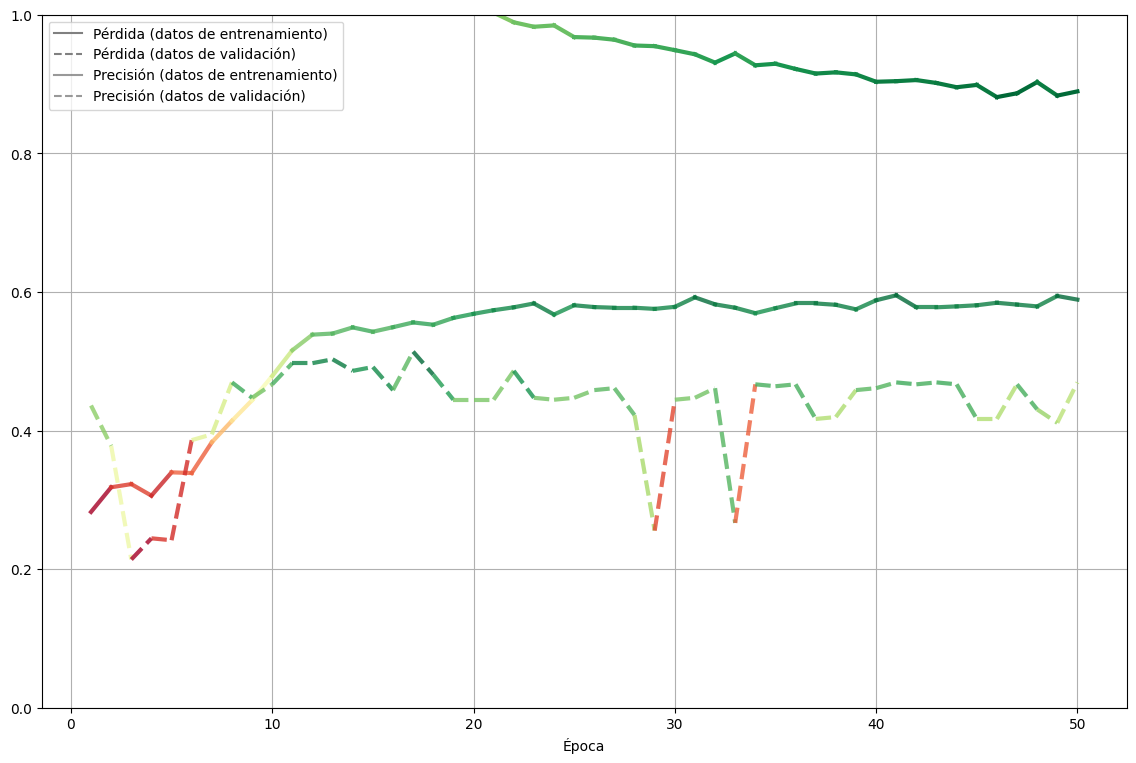

In [ ]:
historial_df = pd.DataFrame(historial.history)

plt.figure(figsize=(14, 9))
plt.grid(True)
plt.gca().set_ylim(0, 1)

#Define color maps
loss_cmap = plt.cm.get_cmap('RdYlGn_r')  # From red to green for losses
acc_cmap = plt.cm.get_cmap('RdYlGn')  # From red to green for accuracy

#Define line width
line_width = 3.0

# Trazar las series de datos y asignar las etiquetas de la leyenda
lines = [color_gradient_plot(historial_df['loss'], 'Pérdida (datos de entrenamiento)', loss_cmap, linewidth=line_width),
         color_gradient_plot(historial_df['val_loss'], 'Pérdida (datos de validación)', loss_cmap, '--', linewidth=line_width),
         color_gradient_plot(historial_df['accuracy'], 'Precisión (datos de entrenamiento)', acc_cmap, alpha=0.8, linewidth=line_width),
         color_gradient_plot(historial_df['val_accuracy'], 'Precisión (datos de validación)', acc_cmap, '--', 0.8, linewidth=line_width)]

plt.xlabel("Época")

# Mostrar la leyenda
leg = plt.legend(handles=lines, loc='best')

plt.show()

**Matriz de confusión**

Con respecto al conjunto de prueba:

10/10 [==============================] - 0s 7ms/step


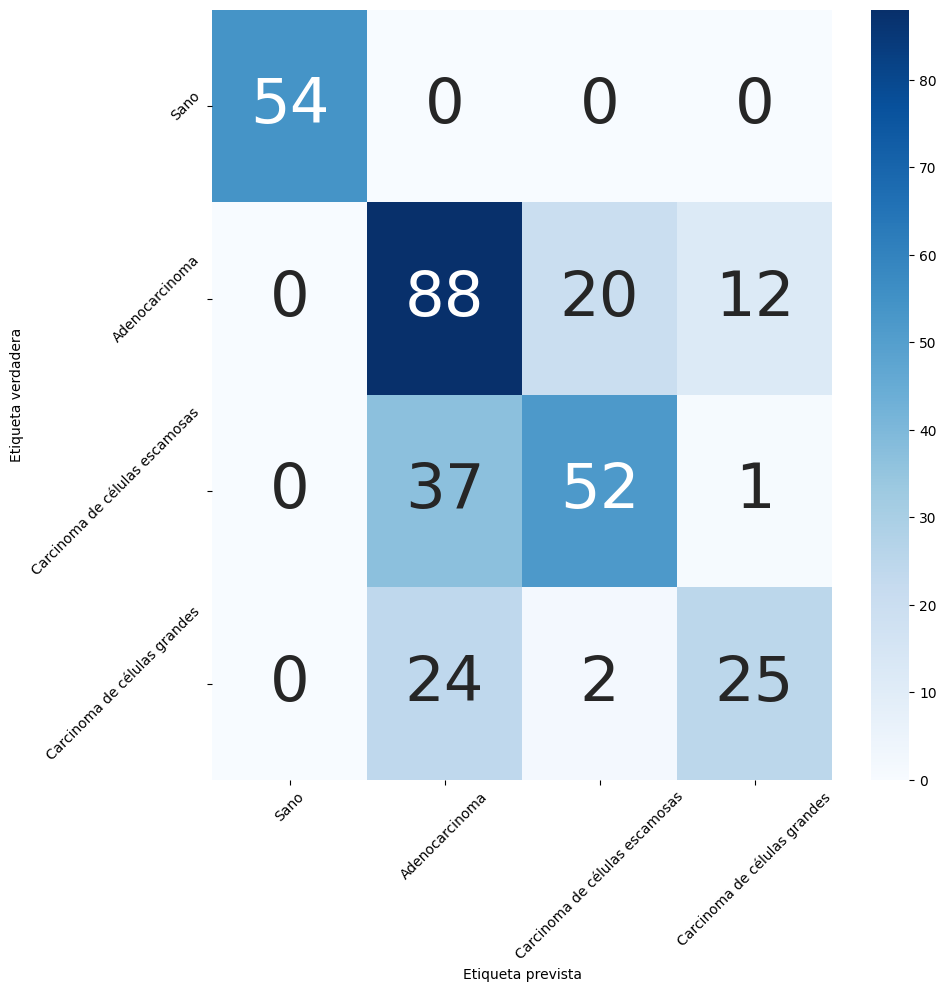

In [ ]:
#Predecir las clases para el conjunto de prueba
y_pred = model.predict(images_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Elige la clase con la probabilidad más alta

#Calcular la matriz de confusión
cm = confusion_matrix(labels_test, y_pred_classes)

#Definir las etiquetas de las clases
class_names = ['Sano', 'Adenocarcinoma', 'Carcinoma de células escamosas', 'Carcinoma de células grandes']

#Mostrar la matriz de confusión
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 45}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta prevista')
plt.ylabel('Etiqueta verdadera')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

**Guardar el modelo** (opcional)

In [ ]:
model.save('/content/drive/MyDrive/Modelos/modelo_cancer_pulmon.h5')

#Para cargar el modelo, utlizamos la siguiente linea de codigo: model = keras.models.load_model('/content/drive/MyDrive/Modelos/modelo_cancer_pulmon.h5')

**Predicción del modelo**

1/1 [==============================] - 0s 26ms/step


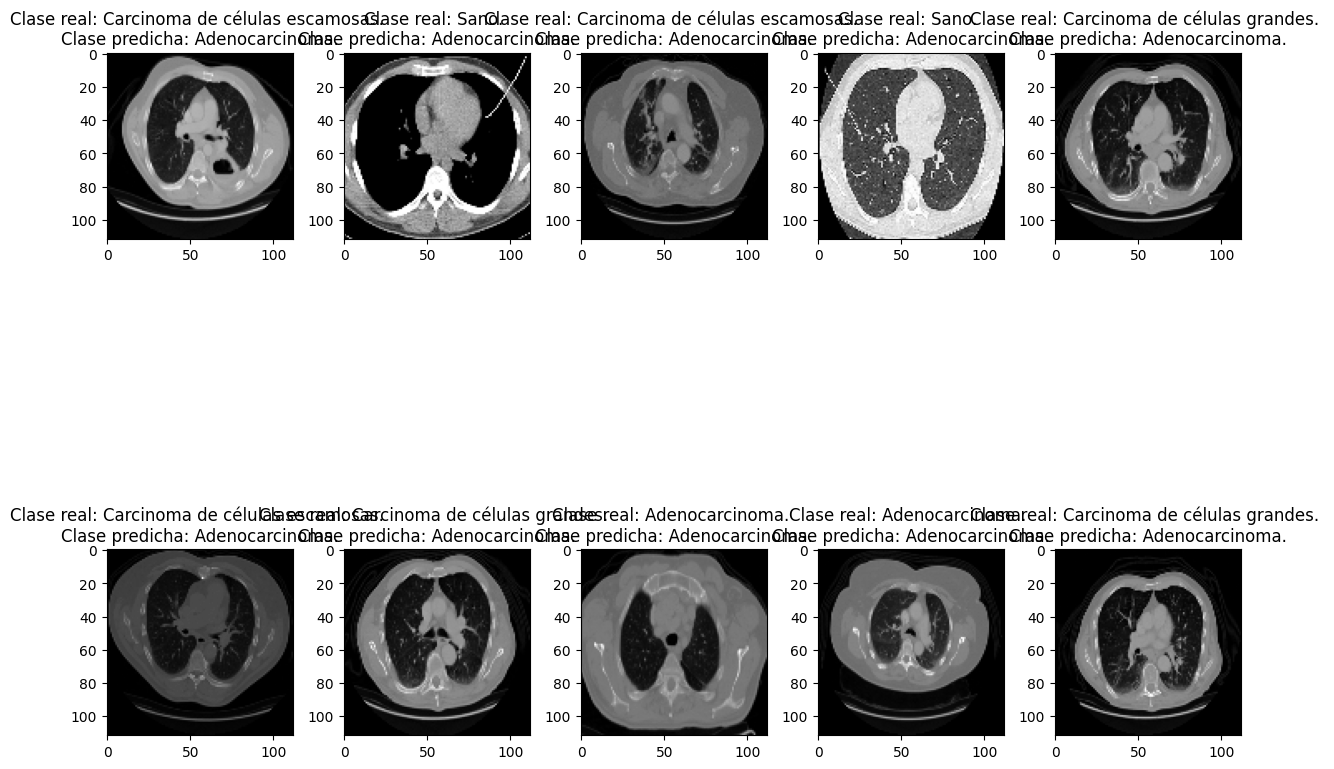

In [ ]:
num_images = 10
fig = plt.figure(figsize=(12, 12))

for i in range(num_images):
    #Imagen aleatoria de los datos de prueba
    index = random.randint(0, len(images_test) - 1)
    img = images_test[index]

    #Prediccion del modelo
    prediccion = model.predict(img[np.newaxis, ...])

    #Clase predicha
    clase_predicha = np.argmax(prediccion)

    #Muestra la imagen junto con la clase real y la predicha
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Clase real: {class_names[labels_test[index]]}. \nClase predicha: {class_names[clase_predicha]}.")

plt.tight_layout()
plt.show()